Dataset saved as data_censored.csv
   id  age  treatment  x1        x2  x3        x4  event_time  censoring  \
0   1   75          1   0 -1.630621   0  0.455393    3.718789          0   
1   2   32          1   1  0.623903   1  0.587576    0.929559          0   
2   3   58          0   0  0.729245   0  0.279542   11.741773          0   
3   4   64          0   0 -0.848274   0  0.453672    6.211098          0   
4   5   68          1   0 -1.448712   0  0.472039   11.513736          0   

      age_s  outcome  eligible  
0  0.918367        1         1  
1  0.040816        1         0  
2  0.571429        0         1  
3  0.693878        0         1  
4  0.775510        1         1  


model,lifelines.CoxPHFitter
duration col,'stop'
event col,'outcome'
weights col,'ipcw'
cluster col,'id'
penalizer,0.01
l1 ratio,0.0
robust variance,True
baseline estimation,breslow
number of observations,258026
number of events observed,87237.4


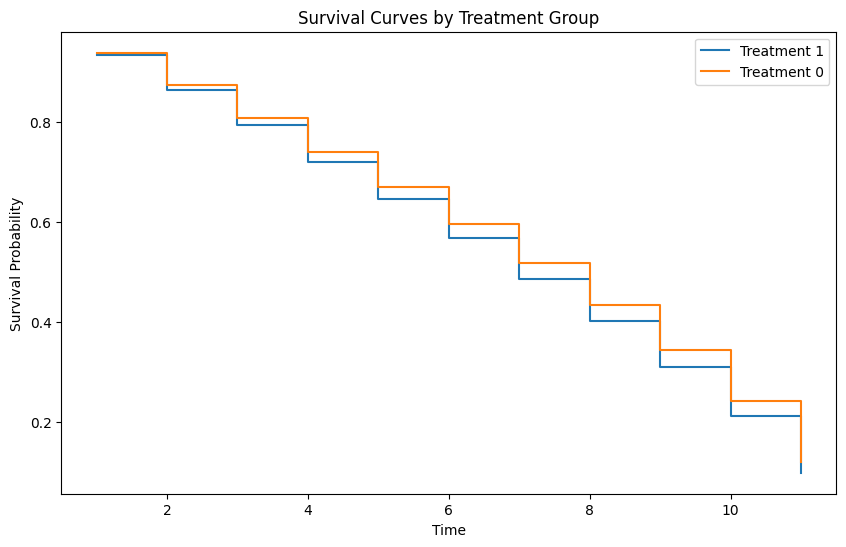

Cluster 1 Summary:
                id         age   treatment          x1          x2     x3  \
count   497.000000  497.000000  497.000000  497.000000  497.000000  497.0   
mean    498.889336   55.016097    0.523139    0.494970   -0.008221    0.0   
std     288.005688   14.383281    0.499968    0.500478    0.970399    0.0   
min       1.000000   30.000000    0.000000    0.000000   -2.944406    0.0   
25%     252.000000   43.000000    0.000000    0.000000   -0.697857    0.0   
50%     499.000000   55.000000    1.000000    0.000000   -0.031966    0.0   
75%     744.000000   67.000000    1.000000    1.000000    0.729245    0.0   
max    1000.000000   79.000000    1.000000    1.000000    3.478448    0.0   

               x4  event_time   censoring       age_s     outcome    eligible  \
count  497.000000  497.000000  497.000000  497.000000  497.000000  497.000000   
mean     0.473233   10.291857    0.046278    0.510533    0.356137    0.883300   
std      0.284410   10.295911    0.210297   

In [7]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import add_covariate_to_timeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(123)

# Generate dummy dataset similar to R's simulate_data function
def generate_dummy_data(sample_size=1000, event_rate=0.1, censoring_rate=0.05, 
                        treatment_effect=0.5, covariate_effects=[0.2, -0.1]):
    data = {
        'id': np.arange(1, sample_size + 1),
        'age': np.random.randint(30, 80, size=sample_size),
        'treatment': np.random.choice([0, 1], size=sample_size),
        'x1': np.random.choice([0, 1], size=sample_size),
        'x2': np.random.normal(0, 1, size=sample_size),
        'x3': np.random.choice([0, 1], size=sample_size),
        'x4': np.random.uniform(0, 1, size=sample_size),
        'event_time': np.random.exponential(1 / event_rate, size=sample_size),
        'censoring': np.random.choice([0, 1], size=sample_size, p=[1 - censoring_rate, censoring_rate])
    }
    df = pd.DataFrame(data)
    df['age_s'] = (df['age'] - df['age'].min()) / (df['age'].max() - df['age'].min())
    df['outcome'] = (df['treatment'] * treatment_effect + 
                     df['x1'] * covariate_effects[0] + 
                     df['x2'] * covariate_effects[1] + 
                     np.random.normal(0, 0.1, size=sample_size)) > 0.5
    df['outcome'] = df['outcome'].astype(int)
    df['eligible'] = (df['age'] > 35).astype(int)
    return df

# Generate data
df = generate_dummy_data()

# Save dataset as CSV
df.to_csv("data_censored.csv", index=False)
print("Dataset saved as data_censored.csv")

# Load and display dataset
data = pd.read_csv("data_censored.csv")
print(data.head())

# Handle Censoring via Inverse Probability of Censoring Weights (IPCW)
censoring_model = LogisticRegression()
features = ['age', 'x1', 'x2', 'x3', 'x4']
X = data[features]
y = data['censoring']
censoring_model.fit(X, y)
data['censoring_prob'] = censoring_model.predict_proba(X)[:, 1]
data['ipcw'] = 1 / np.clip(data['censoring_prob'], 0.01, 10)  # Clip extreme values

# Expand Data into Trial Sequences
max_periods = 10  # Assuming max 10 periods
expanded_data = pd.DataFrame()
for period in range(max_periods + 1):
    period_data = data.copy()
    period_data['time'] = period
    period_data['start'] = period
    period_data['stop'] = period + 1
    expanded_data = pd.concat([expanded_data, period_data])
expanded_data.reset_index(drop=True, inplace=True)

# Drop redundant columns to avoid collinearity before fitting
expanded_data = expanded_data.drop(columns=['time', 'start', 'censoring_prob'], errors='ignore')

# Fit Marginal Structural Models (MSM) using Cox Proportional Hazards model
cph = CoxPHFitter(penalizer=0.01)  # Add L2 regularization
cph.fit(expanded_data, duration_col='stop', event_col='outcome', weights_col='ipcw', cluster_col='id', robust=True)
cph.print_summary()

# Drop 'stop' only after fitting to avoid KeyError
expanded_data = expanded_data.drop(columns=['stop'], errors='ignore')

# Predict survival function
survival_function = cph.predict_survival_function(expanded_data)

# Plot survival curves
plt.figure(figsize=(10, 6))
for i, treatment in enumerate(expanded_data['treatment'].unique()):
    plt.step(survival_function.index, survival_function.iloc[:, i], where='post', label=f'Treatment {treatment}')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Survival Curves by Treatment Group')
plt.legend()
plt.show()

# Integrate Clustering Mechanism
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[features])
kmeans = KMeans(n_clusters=3, random_state=42)
data['cluster'] = kmeans.fit_predict(scaled_features)

# Analyze each cluster separately
for cluster in data['cluster'].unique():
    cluster_data = data[data['cluster'] == cluster]
    print(f"Cluster {cluster} Summary:")
    print(cluster_data.describe())
